# ROC Stories dataset

In [1]:
# importations
import csv
import json
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import pingouin as pg 
from scipy.special import binom
import scipy.stats as st
from scipy.stats import pearsonr, spearmanr, kendalltau
import seaborn as sns
from sklearn.metrics import f1_score
from utils import *

### Loading our data set

In [2]:
 # Opening JSON file
f = open('mans_roc.json')
  
# returns JSON object as 
# a dictionary
data = json.load(f)

In [3]:
data

{'125': {'gen': {'fusion': {'text': 'one day , a car passed her on her lawn . she screamed and ran out to check it out . she realized that it was a broken electrical click . she went online to check on it .',
    'score': [2, 2, 2, 2, 3]},
   's2s': {'text': "she decided to show her job for a living day . she kept going on a act of the princess . her favorite [FEMALE] did n ' t start watching . [FEMALE] ' s face still hit [FEMALE] ' s real watch .",
    'score': [1, 1, 1, 1, 1]},
   'gpt_kg': {'text': "the shows were very hard to find . one day , [FEMALE] 's brother dared her to watch a horror show . [FEMALE] agreed and went home to change to a horror show . after that , [FEMALE] became a fear of watching horror shows .",
    'score': [4, 4, 4, 4, 4]},
   'gpt': {'text': 'she enjoyed writing for a variety show . she also like when celebrity guests came to attend . she used to be a radio personality for one . she was nervous about trying this job after being offered the job .',
    'sco

### Turning our data into a lovely dataframe

In [4]:
import json
import pandas as pd

# Load JSON file into a dictionary
with open('mans_roc.json') as f:
    data_dict = json.load(f)

# Create a list of dictionaries
rows = []
for key, value in data_dict.items():
    for model, model_data in value['gen'].items():
        row = {
            'Story ID': key,
            'Prompt': value['prompt'],
            'Human': value['gold_response'],
            'Story': model_data['text'],
            'Model': model,
            'Human score': model_data['score']
        }
        rows.append(row)

# Convert list of dictionaries to DataFrame
df = pd.DataFrame(rows)


The following story scources are: 'fusion', 's2s', 'gpt_kg', 'gpt', 'plan_write'

In [5]:
mean_fn = lambda x: sum(x) / len(x)

# Apply the mean function to each element of the column
df['Average score'] = df['Human score'].apply(mean_fn)


In [6]:
df

,Story ID,Prompt,Human,Story,Model,Human score,Average score
0,125,[FEMALE] loved watching reality shows .,[FEMALE] 's favorite reality show was the bach...,"one day , a car passed her on her lawn . she s...",fusion,"[2, 2, 2, 2, 3]",2.2
1,125,[FEMALE] loved watching reality shows .,[FEMALE] 's favorite reality show was the bach...,she decided to show her job for a living day ....,s2s,"[1, 1, 1, 1, 1]",1.0
2,125,[FEMALE] loved watching reality shows .,[FEMALE] 's favorite reality show was the bach...,"the shows were very hard to find . one day , [...",gpt_kg,"[4, 4, 4, 4, 4]",4.0
3,125,[FEMALE] loved watching reality shows .,[FEMALE] 's favorite reality show was the bach...,she enjoyed writing for a variety show . she a...,gpt,"[3, 3, 4, 4, 4]",3.6
4,125,[FEMALE] loved watching reality shows .,[FEMALE] 's favorite reality show was the bach...,she started writing stories . she struck a roc...,plan_write,"[1, 1, 2, 2, 2]",1.6
...,...,...,...,...,...,...,...
995,155,we are having a yard sale on saturday .,there is a lot of stuff to get rid of . we are...,[FEMALE] son has recently bought a house . it ...,fusion,"[2, 2, 2, 3, 3]",2.4
996,155,we are having a yard sale on saturday .,there is a lot of stuff to get rid of . we are...,it is fairly wasteful and was not happy . once...,s2s,"[1, 1, 2, 2, 2]",1.6
997,155,we are having a yard sale on saturday .,there is a lot of stuff to get rid of . we are...,the kids are all applying their clothes and ma...,gpt_kg,"[2, 2, 2, 3, 3]",2.4
998,155,we are having a yard sale on saturday .,there is a lot of stuff to get rid of . we are...,i will not be able to go until [FEMALE] . i wi...,gpt,"[3, 4, 4, 4, 4]",3.8


In [7]:
df_human =df.groupby(['Model']).agg({'Average score': lambda x: x.tolist()})
df_human

,Average score
Model,
fusion,"[2.2, 3.4, 3.4, 3.2, 2.6, 2.4, 2.0, 2.0, 1.8, ..."
gpt,"[3.6, 4.2, 2.0, 3.6, 3.0, 3.4, 3.8, 3.0, 4.0, ..."
gpt_kg,"[4.0, 3.8, 3.2, 2.6, 3.4, 3.2, 2.6, 3.4, 2.8, ..."
plan_write,"[1.6, 2.8, 1.4, 2.4, 2.6, 3.2, 2.2, 2.0, 3.0, ..."
s2s,"[1.0, 2.4, 1.4, 1.4, 1.8, 2.2, 1.0, 3.0, 1.8, ..."


### Loading the package OpenMEVA

## Evaluating our dataset on automatic metrics

In [8]:
import json
import pandas as pd

# Load JSON file into a dictionary
with open('mans_roc.json') as f:
    data_dict = json.load(f)

# Create a list of dictionaries
rows = []
for key, value in data_dict.items():
    for model, model_data in value['gen'].items():
        row = {
            'context': value['prompt'],
            'reference': [value['gold_response']],
            'candidate': model_data['text'],
            'model_name': model,
            'score': model_data['score'],
            'metric_score':{}, 
        }
        rows.append(row)

rows


[{'context': '[FEMALE] loved watching reality shows .',
  'reference': ["[FEMALE] 's favorite reality show was the bachelor . [FEMALE] was amazed that 15 women would want to vie for a man 's love . however , what entertained [FEMALE] the most was the drama among the women . [FEMALE] loved the excitement that her favorite television show offered ."],
  'candidate': 'one day , a car passed her on her lawn . she screamed and ran out to check it out . she realized that it was a broken electrical click . she went online to check on it .',
  'model_name': 'fusion',
  'score': [2, 2, 2, 2, 3],
  'metric_score': {}},
 {'context': '[FEMALE] loved watching reality shows .',
  'reference': ["[FEMALE] 's favorite reality show was the bachelor . [FEMALE] was amazed that 15 women would want to vie for a man 's love . however , what entertained [FEMALE] the most was the drama among the women . [FEMALE] loved the excitement that her favorite television show offered ."],
  'candidate': "she decided to 

In [9]:
import json
import os
import copy
import numpy as np
import sys

def test_metric(data):
    from eva.tokenizer import SimpleTokenizer, PretrainedTokenizer
    tokenizer = SimpleTokenizer(method="nltk")
    eva_path = "/home/guanjian/evaluation_dataset/metrics/OpenEva"

    metric_score = {}

    from eva.bleu import BLEU
    bleu_metric = BLEU(tokenizer=SimpleTokenizer(method="nltk"))
    # print(bleu_metric.info())
    metric_score.update(bleu_metric.compute(data))

    #from eva.meteor import METEOR
    #meteor_metric = METEOR()
    # print(meteor_metric.info())
    #metric_score.update(meteor_metric.compute(data))

    from eva.Rouge import ROUGE
    rouge_metric = ROUGE()
    # print(rouge_metric.info())
    metric_score.update(rouge_metric.compute(data))

  
    #from eva.bertscore import BERTScore
    #bertscore_metric = BERTScore(model_type="bert-base-uncased")
    # print(bertscore_metric.info())
    #metric_score.update(bertscore_metric.compute(data))

    #from eva.bleurt import BLEURT # dependency: bleurt from: git+https://github.com/google-research/bleurt.git
    #bleurt_metric = BLEURT(model_type="bleurt-tiny-512", model_path="your_model_path")
    # print(bleurt_metric.info())
    #metric_score.update(bleurt_metric.compute(data))

    #from eva.moverscore import MoverScore
    #moverscore_metric = MoverScore()
    # print(moverscore_metric.info())
    #metric_score.update(moverscore_metric.compute(data, batch_size=8))

    for metric in metric_score:
        for d, r in zip(data, metric_score[metric]):
            d["metric_score"][metric] = r
    return data


In [10]:
df_automatic_metrics= test_metric(rows)

In [11]:
# create a DataFrame from the list of dictionaries
df_metrics = pd.DataFrame(df_automatic_metrics)

#select the desired columns and reorder them
df_metrics = df_metrics[['model_name', 'metric_score', 'score', 'context', 'reference', 'candidate']]

# flatten the nested dictionary in the metric_score column
df_metrics = pd.concat([df_metrics.drop(['metric_score'], axis=1), df_metrics['metric_score'].apply(pd.Series)], axis=1)

# print the resulting DataFrame
print(df_metrics)  

     model_name            score                                  context  \
0        fusion  [2, 2, 2, 2, 3]  [FEMALE] loved watching reality shows .   
1           s2s  [1, 1, 1, 1, 1]  [FEMALE] loved watching reality shows .   
2        gpt_kg  [4, 4, 4, 4, 4]  [FEMALE] loved watching reality shows .   
3           gpt  [3, 3, 4, 4, 4]  [FEMALE] loved watching reality shows .   
4    plan_write  [1, 1, 2, 2, 2]  [FEMALE] loved watching reality shows .   
..          ...              ...                                      ...   
995      fusion  [2, 2, 2, 3, 3]  we are having a yard sale on saturday .   
996         s2s  [1, 1, 2, 2, 2]  we are having a yard sale on saturday .   
997      gpt_kg  [2, 2, 2, 3, 3]  we are having a yard sale on saturday .   
998         gpt  [3, 4, 4, 4, 4]  we are having a yard sale on saturday .   
999  plan_write  [1, 1, 1, 2, 2]  we are having a yard sale on saturday .   

                                             reference  \
0    [[FEMALE] 's

In [12]:
data_scores_roc =df_metrics.groupby(['model_name']).agg({'sentence_bleu': lambda x: x.tolist(),
                            'rouge-1-f': lambda x: x.tolist(),
                            'rouge-1-p': lambda x: x.tolist(),
                            'rouge-1-r': lambda x: x.tolist(),
                            'rouge-2-f': lambda x: x.tolist(),
                            'rouge-2-p': lambda x: x.tolist(),
                           'rouge-2-r': lambda x: x.tolist(),
                            'rouge-l-f': lambda x: x.tolist(),
                           'rouge-l-p': lambda x: x.tolist(),
                            'rouge-l-r': lambda x: x.tolist()})

data_scores_roc

,sentence_bleu,rouge-1-f,rouge-1-p,rouge-1-r,rouge-2-f,rouge-2-p,rouge-2-r,rouge-l-f,rouge-l-p,rouge-l-r
model_name,,,,,,,,,,
fusion,"[0.004923920337524665, 0.01209685959137829, 0....","[0.2105263108648816, 0.15094339137059468, 0.16...","[0.24, 0.12903225806451613, 0.1470588235294117...","[0.1875, 0.18181818181818182, 0.17857142857142...","[0.0, 0.0298507414034314, 0.0, 0.0404040354045...","[0.0, 0.02564102564102564, 0.0, 0.04, 0.0, 0.0...","[0.0, 0.03571428571428571, 0.0, 0.040816326530...","[0.2105263108648816, 0.11320754231399095, 0.16...","[0.24, 0.0967741935483871, 0.14705882352941177...","[0.1875, 0.13636363636363635, 0.17857142857142..."
gpt,"[0.009176281753797672, 0.017398984878730765, 0...","[0.22580644661810625, 0.17777777278024703, 0.2...","[0.23333333333333334, 0.17391304347826086, 0.1...","[0.21875, 0.18181818181818182, 0.25, 0.0526315...","[0.024999995050000976, 0.0, 0.0714285666099776...","[0.027777777777777776, 0.0, 0.06, 0.0, 0.0, 0....","[0.022727272727272728, 0.0, 0.0882352941176470...","[0.22580644661810625, 0.17777777278024703, 0.2...","[0.23333333333333334, 0.17391304347826086, 0.1...","[0.21875, 0.18181818181818182, 0.25, 0.0526315..."
gpt_kg,"[0.1329677180727818, 0.0203319756189382, 0.014...","[0.29032257565036423, 0.14999999505000017, 0.1...","[0.3, 0.16666666666666666, 0.1724137931034483,...","[0.28125, 0.13636363636363635, 0.1785714285714...","[0.02439023892920982, 0.0, 0.0, 0.0, 0.0, 0.0,...","[0.02631578947368421, 0.0, 0.0, 0.0, 0.0, 0.0,...","[0.022727272727272728, 0.0, 0.0, 0.0, 0.0, 0.0...","[0.29032257565036423, 0.14999999505000017, 0.1...","[0.3, 0.16666666666666666, 0.1724137931034483,...","[0.28125, 0.13636363636363635, 0.1785714285714..."
plan_write,"[0.00837296922373548, 0.008447063994683927, 0....","[0.15999999539200013, 0.04878048283164834, 0.2...","[0.2222222222222222, 0.05263157894736842, 0.30...","[0.125, 0.045454545454545456, 0.25, 0.15789473...","[0.0, 0.0, 0.0, 0.05479451613435952, 0.0344827...","[0.0, 0.0, 0.0, 0.08333333333333333, 0.0384615...","[0.0, 0.0, 0.0, 0.04081632653061224, 0.03125, ...","[0.15999999539200013, 0.04878048283164834, 0.2...","[0.2222222222222222, 0.05263157894736842, 0.30...","[0.125, 0.045454545454545456, 0.25, 0.15789473..."
s2s,"[0.1427572971712664, 0.005943511191482252, 0.0...","[0.2539682489695138, 0.13793102977407862, 0.14...","[0.25806451612903225, 0.1111111111111111, 0.13...","[0.25, 0.18181818181818182, 0.1428571428571428...","[0.04999999505000049, 0.0, 0.0, 0.0, 0.0, 0.02...","[0.05555555555555555, 0.0, 0.0, 0.0, 0.0, 0.02...","[0.045454545454545456, 0.0, 0.0, 0.0, 0.0, 0.0...","[0.2539682489695138, 0.13793102977407862, 0.14...","[0.25806451612903225, 0.1111111111111111, 0.13...","[0.25, 0.18181818181818182, 0.1428571428571428..."


In [13]:
data_scores_roc[['Human score']]= df_human[['Average score']]
data_scores_roc

,sentence_bleu,rouge-1-f,rouge-1-p,rouge-1-r,rouge-2-f,rouge-2-p,rouge-2-r,rouge-l-f,rouge-l-p,rouge-l-r,Human score
model_name,,,,,,,,,,,
fusion,"[0.004923920337524665, 0.01209685959137829, 0....","[0.2105263108648816, 0.15094339137059468, 0.16...","[0.24, 0.12903225806451613, 0.1470588235294117...","[0.1875, 0.18181818181818182, 0.17857142857142...","[0.0, 0.0298507414034314, 0.0, 0.0404040354045...","[0.0, 0.02564102564102564, 0.0, 0.04, 0.0, 0.0...","[0.0, 0.03571428571428571, 0.0, 0.040816326530...","[0.2105263108648816, 0.11320754231399095, 0.16...","[0.24, 0.0967741935483871, 0.14705882352941177...","[0.1875, 0.13636363636363635, 0.17857142857142...","[2.2, 3.4, 3.4, 3.2, 2.6, 2.4, 2.0, 2.0, 1.8, ..."
gpt,"[0.009176281753797672, 0.017398984878730765, 0...","[0.22580644661810625, 0.17777777278024703, 0.2...","[0.23333333333333334, 0.17391304347826086, 0.1...","[0.21875, 0.18181818181818182, 0.25, 0.0526315...","[0.024999995050000976, 0.0, 0.0714285666099776...","[0.027777777777777776, 0.0, 0.06, 0.0, 0.0, 0....","[0.022727272727272728, 0.0, 0.0882352941176470...","[0.22580644661810625, 0.17777777278024703, 0.2...","[0.23333333333333334, 0.17391304347826086, 0.1...","[0.21875, 0.18181818181818182, 0.25, 0.0526315...","[3.6, 4.2, 2.0, 3.6, 3.0, 3.4, 3.8, 3.0, 4.0, ..."
gpt_kg,"[0.1329677180727818, 0.0203319756189382, 0.014...","[0.29032257565036423, 0.14999999505000017, 0.1...","[0.3, 0.16666666666666666, 0.1724137931034483,...","[0.28125, 0.13636363636363635, 0.1785714285714...","[0.02439023892920982, 0.0, 0.0, 0.0, 0.0, 0.0,...","[0.02631578947368421, 0.0, 0.0, 0.0, 0.0, 0.0,...","[0.022727272727272728, 0.0, 0.0, 0.0, 0.0, 0.0...","[0.29032257565036423, 0.14999999505000017, 0.1...","[0.3, 0.16666666666666666, 0.1724137931034483,...","[0.28125, 0.13636363636363635, 0.1785714285714...","[4.0, 3.8, 3.2, 2.6, 3.4, 3.2, 2.6, 3.4, 2.8, ..."
plan_write,"[0.00837296922373548, 0.008447063994683927, 0....","[0.15999999539200013, 0.04878048283164834, 0.2...","[0.2222222222222222, 0.05263157894736842, 0.30...","[0.125, 0.045454545454545456, 0.25, 0.15789473...","[0.0, 0.0, 0.0, 0.05479451613435952, 0.0344827...","[0.0, 0.0, 0.0, 0.08333333333333333, 0.0384615...","[0.0, 0.0, 0.0, 0.04081632653061224, 0.03125, ...","[0.15999999539200013, 0.04878048283164834, 0.2...","[0.2222222222222222, 0.05263157894736842, 0.30...","[0.125, 0.045454545454545456, 0.25, 0.15789473...","[1.6, 2.8, 1.4, 2.4, 2.6, 3.2, 2.2, 2.0, 3.0, ..."
s2s,"[0.1427572971712664, 0.005943511191482252, 0.0...","[0.2539682489695138, 0.13793102977407862, 0.14...","[0.25806451612903225, 0.1111111111111111, 0.13...","[0.25, 0.18181818181818182, 0.1428571428571428...","[0.04999999505000049, 0.0, 0.0, 0.0, 0.0, 0.02...","[0.05555555555555555, 0.0, 0.0, 0.0, 0.0, 0.02...","[0.045454545454545456, 0.0, 0.0, 0.0, 0.0, 0.0...","[0.2539682489695138, 0.13793102977407862, 0.14...","[0.25806451612903225, 0.1111111111111111, 0.13...","[0.25, 0.18181818181818182, 0.1428571428571428...","[1.0, 2.4, 1.4, 1.4, 1.8, 2.2, 1.0, 3.0, 1.8, ..."


### Correlation between our automated metrics and our human score: using story and system correlation for our ROCStories database

In [17]:
# story-level correlation

def story_level_plot(data,
                     metrics1,
                      metrics2,
                     path, 
                      criterion, 
                      plot_size=  (30,45)):
    # metrics 1 is a list with the names of the metric you want your lines to be
    # metrics 2 is a list with the names of the metric you want your columns to be
    # criterion is either 'kendall', 'spearman' or 'pearson'
    # plot_size is a tuple with the plot size you want
    
    N=len(metrics1)
    M=len(metrics2)
    corr_story_matrix= np.zeros((N, M))
    for i in range(N):
        for j in range(M):
            c_metric1= np.array( [l for l in data[metrics1[i]].tolist()]).T
            c_metric2= np.array( [l for l in data[metrics2[j]].tolist()]).T
    
         
            if criterion== 'kendall':
                k=np.zeros(96)
                for l in range(96):
                    k[l]=kendalltau(c_metric1[l],c_metric2[l] )[0]
                corr_story_matrix[i,j]=abs(round(100*k.mean()))

            elif criterion== 'pearson':
                k=np.zeros(96)
                for l in range(96):
                    k[l]=pearsonr(c_metric1[l],c_metric2[l] )[0]
                corr_story_matrix[i,j]= abs(round(100*k.mean()))
    
            elif criterion== 'spearman':
                k=np.zeros(96)
                for l in range(96):
                    k[l]=spearmanr(c_metric1[l],c_metric2[l] )[0]
                corr_story_matrix[i,j]=abs(round(100*k.mean()))
            
    plt.figure(figsize = plot_size)
    heatmap=sns.heatmap(corr_story_matrix, 
                    annot=True, 
                    cmap='coolwarm', square=True, vmin=0, vmax=100,
                    xticklabels=metrics2,
                    yticklabels=metrics1,cbar=False)


    heatmap.set_xticklabels(heatmap.get_xticklabels(), rotation=45, ha='right')
    plt.savefig(path, dpi=600)
    # Display the plot
    plt.show() 

In [20]:
data_scores_roc.columns
datas_scores_roc2= [ 'rouge-1-f', 'rouge-1-p', 'rouge-1-r', 'rouge-l-f', 'rouge-l-p', 'rouge-l-r']

## Story-level absolute Kendall correlations (%) between metrics

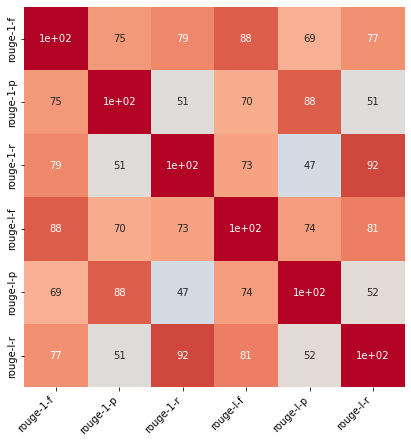

In [21]:

story_level_plot(data_scores_roc, datas_scores_roc2, datas_scores_roc2, 'Figures/fig1_roc.jpg', 'kendall', (7,7))

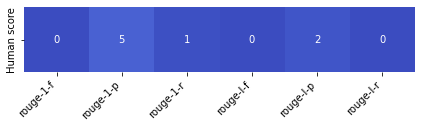

In [22]:

story_level_plot( data_scores_roc, ['Human score'], datas_scores_roc2, 'Figures/fig1_roc.jpg', 'kendall', (7,7))

In [30]:
# system-level correlation

def system_level_plot(data, 
                      metrics1,
                      metrics2,
                      path,
                      criterion, 
                      plot_size=  (30,45)):
    # metrics 1 is a list with the names of the metric you want your lines to be
    # metrics 2 is a list with the names of the metric you want your columns to be
    # criterion is either 'kendall', 'spearman' or 'pearson'
    # plot_size is a tuple with the plot size you want
    
    N=len(metrics1)
    M=len(metrics2)
    corr_story_matrix= np.zeros((N, M))
    for i in range(N):
        for j in range(M):
            c_metric1= np.array( [l for l in data[metrics1[i]].tolist()]).T
            c_metric2= np.array( [l for l in data[metrics2[j]].tolist()]).T
            
            if criterion== 'kendall':
                
                k= kendalltau( np.mean(c_metric1, axis=0),np.mean(c_metric2, axis=0) )[0]
                corr_story_matrix[i,j]= abs(round(100*k))
            elif criterion== 'pearson':
                
                k= pearsonr( np.mean(c_metric1, axis=0),np.mean(c_metric2, axis=0) )[0]
                corr_story_matrix[i,j]= abs(round(100*k))
            
            elif criterion== 'spearman':
                
                k= spearmanr( np.mean(c_metric1, axis=0),np.mean(c_metric2, axis=0) )[0]
                corr_story_matrix[i,j]=abs(round(100*k))

    plt.figure(figsize = plot_size)
    heatmap=sns.heatmap(corr_story_matrix, 
                    annot=True, 
                    cmap='coolwarm', square=True, vmin=0, vmax=50,
                    xticklabels=metrics2,
                    yticklabels=metrics1,cbar=False)


    heatmap.set_xticklabels(heatmap.get_xticklabels(), rotation=45, ha='right')
    plt.savefig(path)
    # Display the plot
    plt.show() 

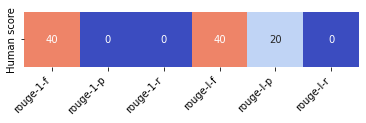

In [33]:

system_level_plot( data_scores_roc, ['Human score'], datas_scores_roc2, 'Figures/fig2_roc.jpg', 'kendall', (6,2.2))

In [151]:
import torch
torch.cuda.is_available()

False